In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from astropy.table import Table

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
ls ../data/

EPIC_211309989_mast.fits             ktwo201367065-c01_lpd-targ.fits.gz
ktwo200128910-c111_lpd-targ.fits.gz  ktwo205897543-c03_lpd-targ.fits.gz
ktwo200147465-c112_lpd-targ.fits.gz  ktwo211309989-c05_llc.fits
ktwo200147465-c112_spd-targ.fits.gz  ktwo211309989-c05_lpd-targ.fits.gz
ktwo200173843-c13_lpd-targ.fits      nuInd/


In [3]:
fname = "../data/ktwo200173843-c13_lpd-targ.fits" # aldebaran


In [4]:
tpf = halo_tpf(fname)

/anaconda3/lib/python3.7/site-packages/lightkurve/targetpixelfile.py:1331: LightkurveWarning: A Kepler data product is being opened using the `TessTargetPixelFile` class. Please use `KeplerTargetPixelFile` instead.
  LightkurveWarning)


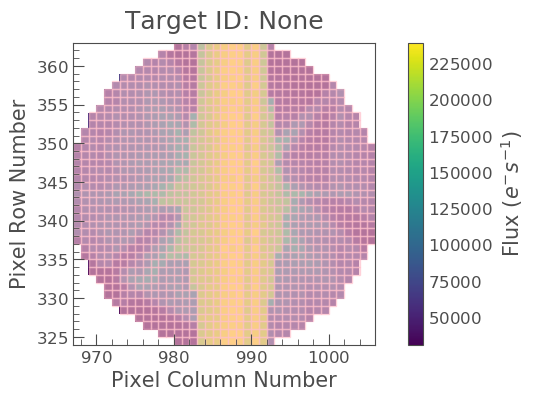

In [5]:
tpf.plot(frame=1,aperture_mask=tpf.pipeline_mask)

In [6]:
lc = tpf.to_lightcurve()
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


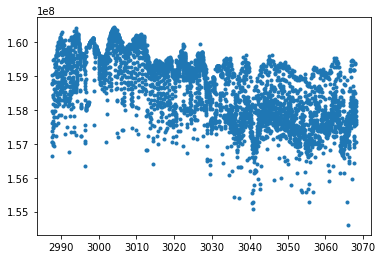

In [7]:
plt.plot(lc.time, lc.flux,'.')


## Now to do Halophot


In [8]:
tpf = halo_tpf(fname)

/anaconda3/lib/python3.7/site-packages/lightkurve/targetpixelfile.py:1331: LightkurveWarning: A Kepler data product is being opened using the `TessTargetPixelFile` class. Please use `KeplerTargetPixelFile` instead.
  LightkurveWarning)


In [9]:
%%time
weightmap, corr_lc = tpf.halo(order=1,split_times=[3010],thresh=-1);

/anaconda3/lib/python3.7/site-packages/lightkurve/targetpixelfile.py:479: LightkurveWarning: `TargetPixelFile.centroids()` is deprecated and will be removed in Lightkurve v1.0.0, please use `TargetPixelFile.estimate_centroids()` instead.
  LightkurveWarning)


Taking cadences from beginning to 1084
Searching for number of saturated pixels to cut between 1051 and 1165
Finished optimization: 1057 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 1084 to end
Searching for number of saturated pixels to cut between 1068 and 1176
Finished optimization: 1098 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 5min 22s, sys: 8.74 s, total: 5min 31s
Wall time: 1min 24s


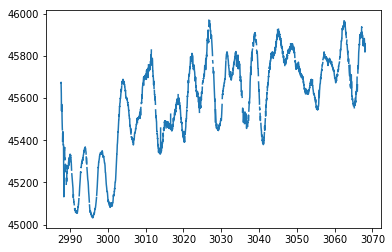

In [10]:
plt.plot(corr_lc.time,corr_lc.flux)

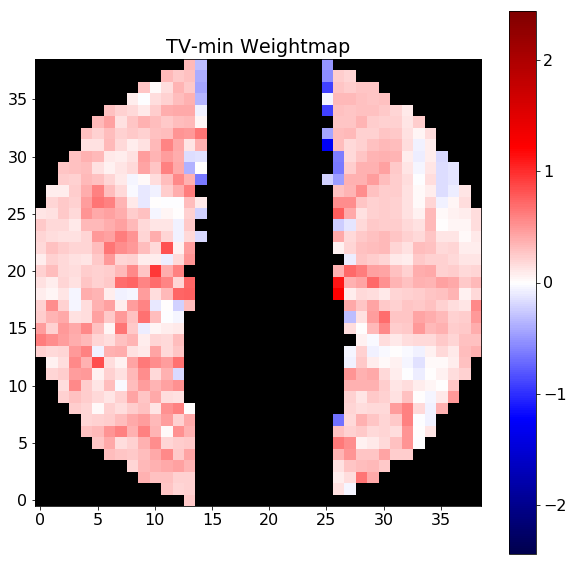

In [69]:
cmap = mpl.cm.seismic
norm = np.size(weightmap)
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title('TV-min Weightmap')
plt.savefig('aldebaran_weightmap.png')

In [12]:
from astropy.io import fits

In [13]:
f = fits.PrimaryHDU(weightmap)

In [14]:
f.writeto('aldebaran_weightmap.fits',overwrite=True)

### Now let's try and correct it with k2sc

In [15]:
import k2sc
from k2sc import standalone

corr_lc.__class__ = standalone.k2sc_lc

In [16]:
corr_lc.k2sc()

Using default splits [2344] for campaign 5
Starting initial outlier detection
  Flagged 165 ( 0.0%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    5.75 (fap 1.8134e-171 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
('  DE iteration %3i -ln(L) %4.1f', 0, -5450.16664785671)
('  DE iteration %3i -ln(L) %4.1f', 1, -5538.37435055875)
('  DE iteration %3i -ln(L) %4.1f', 2, -5538.37435055875)
('  DE iteration %3i -ln(L) %4.1f', 3, -5538.37435055875)
('  DE iteration %3i -ln(L) %4.1f', 4, -5538.37435055875)
('  DE iteration %3i -ln(L) %4.1f', 5, -5556.885714615515)
('  DE iteration %3i -ln(L) %4.1f', 6, -5556.885714615515)
('  DE iteration %3i -ln(L) %4.1f', 7, -5565.577656381866)
('  DE iteration %3i -ln(L) %4.1f', 8, -5619.808648917985)
('  DE iteration %3i -ln(L) %4.1f', 9, -5619.808648917985)
('  DE iteration %3i -ln(L) %4.1f', 10, -5619.808648917985)
('  DE iteration %3i -ln(L) %4.1f'

Text(0.5,1.01,'Aldebaran')

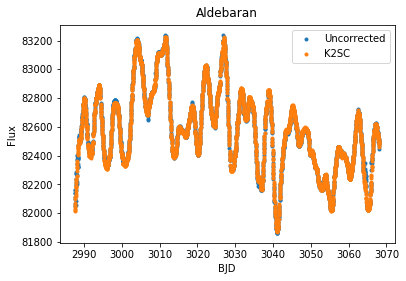

In [17]:
plt.plot(corr_lc.time,corr_lc.flux,'.',label="Uncorrected")
plt.plot(corr_lc.time,corr_lc.corr_flux,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('Aldebaran',y=1.01)